In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import normaltest

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
sns.set_palette('muted')

## Contents
1. [Load & Visualize Time Series](#load_viz)
2. [Change Point Detection](#cpd)
3. [Autocorrelation Functions (ACF/PACF)](#acf_pacf)
4. [ARIMA Modeling](#arima_modeling), [ARIMA Forecasting](#arima_forecasting)
5. [Exogenous Variables](#exog)
6. [Modeling with Exogenous Variables](#exog_modeling), [Forecasting with Exogenous Variables](#exog_forecasting)

<a id='load_viz'></a>
## Load & Visualize Time Series

In [2]:
eth_raw = pd.read_pickle('eth_df.pkl')
print(eth_raw.info())
eth_raw.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 7 columns):
date          1131 non-null datetime64[ns]
open          1131 non-null float64
high          1131 non-null float64
low           1131 non-null float64
close         1131 non-null float64
volumefrom    1131 non-null float64
volumeto      1131 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 61.9 KB
None


,date,open,high,low,close,volumefrom,volumeto
0,2015-08-06,0.6747,3.0,0.6747,3.0,123.93,371.79
1,2015-08-07,3.0000,3.0,0.1500,1.2,2119.43,1438.16


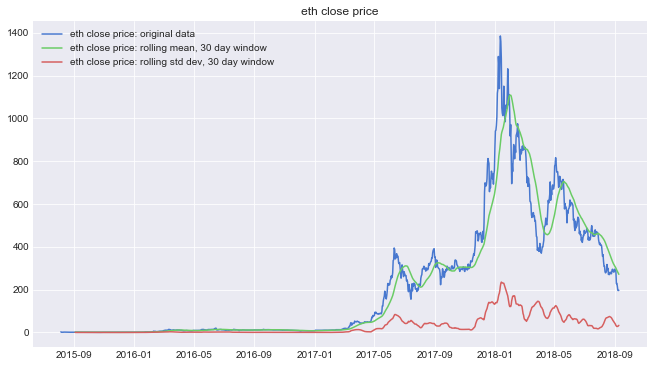

adf: -1.807060571948588
pval: 0.37696199282738063
critical vals {'1%': -3.436270983129607, '5%': -2.8641544150183553, '10%': -2.5681619941180744}


In [3]:
df = eth_raw.copy()
df.rename(columns={'close':'eth'}, inplace=True)
plt.figure(figsize=(11,6))
plt.plot(
    df['date'],
    df['eth'],
    label='eth close price: original data'
)
plt.plot(
    df['date'],
    df['eth'].rolling(30).mean(),
    label='eth close price: rolling mean, 30 day window'
)
plt.plot(
    df['date'],
    df['eth'].rolling(30).std(),
    label='eth close price: rolling std dev, 30 day window'
)
plt.title('eth close price')
plt.legend(loc='upper left')
plt.show()

from statsmodels.tsa.stattools import adfuller
print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(df['eth'])[0],
    adfuller(df['eth'])[1],
    adfuller(df['eth'])[4]))

**Interpretation:**
- Data displays trend
- Graph indicates presence of structural breaks
- Data does not show stationarity
- ADF test confirms data is not stationary

<a id='cpd'></a>
## Change Point Detection
- [Ruptures Library](https://github.com/deepcharles/ruptures) used for change point detection
- Pruned Exact Linear Time (PELT): penalized change point detection algorithm

In [4]:
ts = df[['date', 'eth']]
ts = ts.set_index('date')

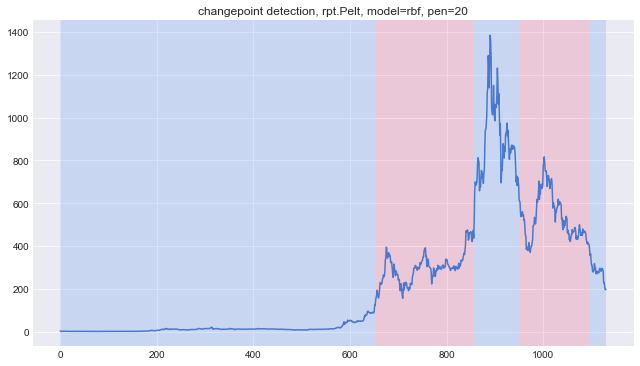

[655, 855, 950, 1095, 1131]


In [5]:
import ruptures as rpt
cpts = rpt.Pelt(model='rbf').fit_predict(ts, pen=20)

rpt.display(ts, cpts, figsize=(9,5))
plt.title('changepoint detection, rpt.Pelt, model=rbf, pen=20')
plt.show()
print(cpts)

In [6]:
# split df by changepoints
df_01 = df[:655]
df_02 = df[655:855]
df_03 = df[855:950]
df_04 = df[950:1095]
df_05 = df[1095:]

#print(len(df_01) + len(df_02) + len(df_03) + len(df_04))
#print(len(df))

In [7]:
# a few attempts at stationarity
df_05['diff_1'] = df_05.eth - df_05.eth.shift(1)
df_05['diff_2'] = df_05.eth - df_05.eth.shift(2)
df_05['log'] = np.log(df_05.eth)
df_05['log_diff_1'] = np.log(df_05.eth).diff().dropna()
df_05['sqrt'] = np.sqrt(df_05.eth)

# drop nans from differencing
df_05 = df_05[2:]
#df_04.head()

print('\ndiff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['diff_1'])[0],
    adfuller(df_05['diff_1'])[1],
    adfuller(df_05['diff_1'])[4]))

print('\ndiff_2\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['diff_2'])[0],
    adfuller(df_05['diff_2'])[1],
    adfuller(df_05['diff_2'])[4]))

print('\nlog\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['log'])[0],
    adfuller(df_05['log'])[1],
    adfuller(df_05['log'])[4]))

print('\nlog_diff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['log_diff_1'])[0],
    adfuller(df_05['log_diff_1'])[1],
    adfuller(df_05['log_diff_1'])[4]))

print('\nsqrt\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['sqrt'])[0],
    adfuller(df_05['sqrt'])[1],
    adfuller(df_05['sqrt'])[4]))


diff_1
adf=-6.5085786025456995, npval=1.1150764113091709e-08
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}

diff_2
adf=-3.349462014687139, npval=0.012807192888507752
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}

log
adf=-0.6010174187237314, npval=0.8707519661589569
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}

log_diff_1
adf=-6.30552672373701, npval=3.330885906418666e-08
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}

sqrt
adf=-0.8443103817570272, npval=0.8057585973877541
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}


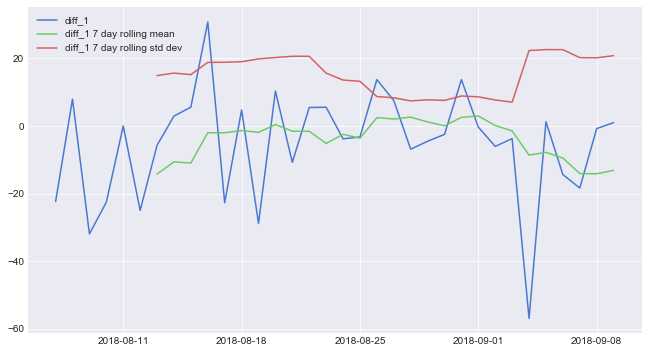


diff_1
adf=-6.5085786025456995, npval=1.1150764113091709e-08
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}


In [8]:
window = 7

plt.figure(figsize=(11,6))
plt.plot(df_05.date,
         df_05.diff_1,
         label='diff_1')
plt.plot(df_05.date,
         df_05.diff_1.rolling(window).mean(),
         label='diff_1 {} day rolling mean'.format(window))
plt.plot(df_05.date,
         df_05.diff_1.rolling(window).std(),
         label='diff_1 {} day rolling std dev'.format(window))
plt.legend()
plt.show()

print('\ndiff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['diff_1'])[0],
    adfuller(df_05['diff_1'])[1],
    adfuller(df_05['diff_1'])[4]))

<a id='acf_pacf'></a>
## Autocorrelation Functions (ACF/PACF)

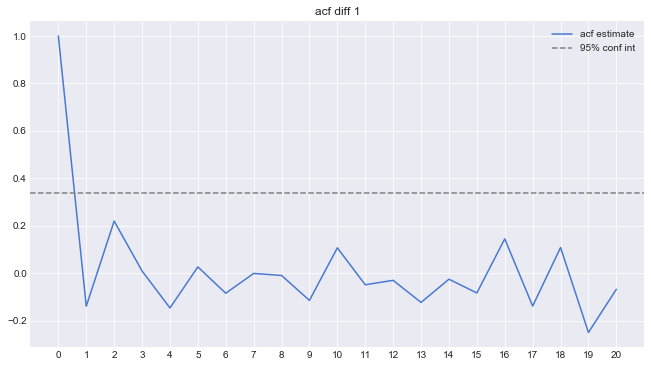

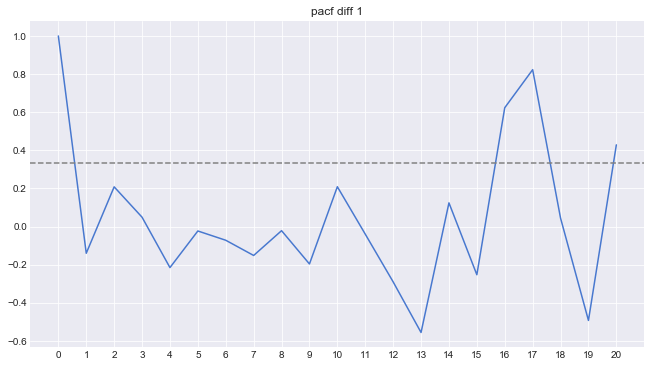

In [9]:
diff_1_acf = acf(df_05.diff_1, nlags=20)
diff_1_pacf = pacf(df_05.diff_1, nlags=20, method='ols')

plt.figure(figsize=(11,6))
plt.plot(diff_1_acf, label='acf estimate')
plt.axhline(y=1.96/np.sqrt(len(df_05.diff_1)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('acf diff 1')
plt.legend()
plt.show()

plt.figure(figsize=(11,6))
plt.plot(diff_1_pacf, label='pacf estimate')
plt.axhline(y=1.96/np.sqrt(len(df_05.diff_1)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('pacf diff 1')
plt.show()

<a id='arima_modeling'></a>
## ARIMA Modeling
- Using statsmodels SARIMAX implementation as it is the most current, upkept, and bug free implementation
- Not using seasonal components, this data does not show seasonality

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df_05.eth

def rmse(model):
    rmse = np.sqrt((model.resid ** 2).mean())
    return rmse

In [11]:
base = SARIMAX(
    endog=y,
    order=(0,0,0)
).fit()
print(base.summary())
print('\nbase rmse = {}'.format(rmse(base)))

                           Statespace Model Results                           
Dep. Variable:                    eth   No. Observations:                   34
Model:                        SARIMAX   Log Likelihood                -240.104
Date:                Tue, 11 Sep 2018   AIC                            482.207
Time:                        16:42:58   BIC                            483.734
Sample:                             0   HQIC                           482.728
                                 - 34                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.969e+04   1.04e+05      0.767      0.443   -1.24e+05    2.83e+05
Ljung-Box (Q):                      259.67   Jarque-Bera (JB):                 1.77
Prob(Q):                              0.00   Pr

In [12]:
d1 = SARIMAX(
    endog=y,
    order=(0,1,0)
).fit()
print(d1.summary())
print('\nd1 rmse= {}'.format(rmse(d1)))

                           Statespace Model Results                           
Dep. Variable:                    eth   No. Observations:                   34
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -139.837
Date:                Tue, 11 Sep 2018   AIC                            281.674
Time:                        16:42:58   BIC                            283.170
Sample:                             0   HQIC                           282.177
                                 - 34                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       280.6656     45.987      6.103      0.000     190.532     370.799
Ljung-Box (Q):                       29.97   Jarque-Bera (JB):                 9.71
Prob(Q):                              0.57   Pr

In [13]:
ar1 = SARIMAX(
    endog=y,
    order=(1,1,0)
).fit()
print(ar1.summary())
print('\nar1 rmse = {}'.format(rmse(ar1)))

                           Statespace Model Results                           
Dep. Variable:                    eth   No. Observations:                   34
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -139.831
Date:                Tue, 11 Sep 2018   AIC                            283.662
Time:                        16:42:58   BIC                            286.655
Sample:                             0   HQIC                           284.669
                                 - 34                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0182      0.241     -0.076      0.940      -0.490       0.453
sigma2       280.5479     46.369      6.050      0.000     189.665     371.430
Ljung-Box (Q):                       29.71   Jarque-

In [14]:
ma1 = SARIMAX(
    endog=y,
    order=(0,1,1)
).fit()
print(ma1.summary())
print('\nma1 rmse = {}'.format(rmse(ma1)))

                           Statespace Model Results                           
Dep. Variable:                    eth   No. Observations:                   34
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -139.833
Date:                Tue, 11 Sep 2018   AIC                            283.666
Time:                        16:42:58   BIC                            286.659
Sample:                             0   HQIC                           284.673
                                 - 34                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0125      0.241     -0.052      0.959      -0.485       0.460
sigma2       280.5788     46.457      6.039      0.000     189.524     371.634
Ljung-Box (Q):                       29.78   Jarque-

In [15]:
combined = SARIMAX(
    endog=y,
    order=(1,1,1)
).fit()
print(combined.summary())
print('\ncombined rmse = {}'.format(rmse(combined)))

                           Statespace Model Results                           
Dep. Variable:                    eth   No. Observations:                   34
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -139.705
Date:                Tue, 11 Sep 2018   AIC                            285.409
Time:                        16:42:58   BIC                            289.899
Sample:                             0   HQIC                           286.920
                                 - 34                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7834      0.959      0.817      0.414      -1.096       2.663
ma.L1         -0.7246      1.027     -0.706      0.480      -2.737       1.288
sigma2       278.2346     46.420      5.994      0.0

**Results:** Autoregressive or moving average components appear to be very small or non-existent for this data. Compared to a base model on first order differenced data, AR(1), MA(1) and combined order(1,1,1) models return higher (worse) AIC scores and non-significant coefficients. However, their RMSE's are slightly lower than the base model, though this is could be the result of some overfitting.

<a id='arima_forecasting'></a>
### Forecasting
- Forecast last 7 days of time series with d1 and ar1 models

In [16]:
y_train = y[:-7]
y_test = y[-7:]

In [17]:
d1 = SARIMAX(
    endog=y_train,
    order=(0,1,0)
).fit()

d1_fc = d1.forecast(steps=7)
d1_fc_resid = d1_fc.values - y_test.values
rmse_d1_fc = np.sqrt((d1_fc_resid ** 2).mean())

In [18]:
ar1 = SARIMAX(
    endog=y_train,
    order=(1,1,0)
).fit()

ar1_fc = ar1.forecast(steps=7)
ar1_fc_resid = ar1_fc.values - y_test.values
rmse_ar1_fc = np.sqrt((ar1_fc_resid ** 2).mean())

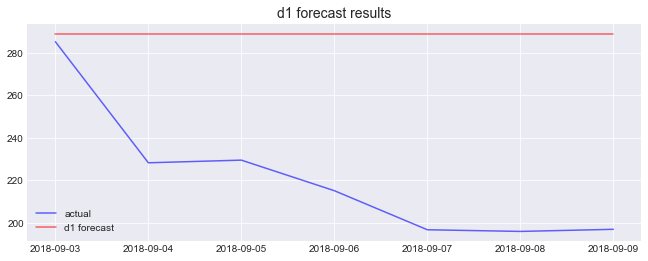

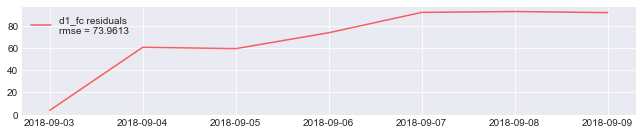

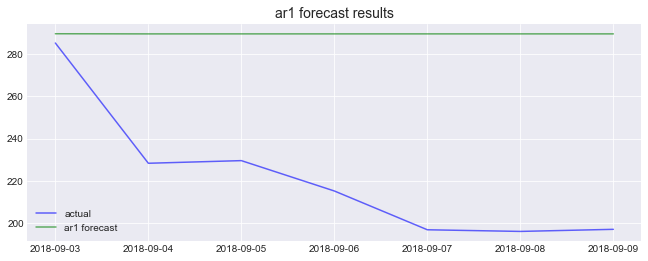

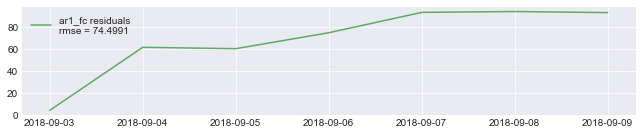

In [19]:
# plot results
alpha=.6

# d1 forecast results
plt.figure(figsize=(11,4))
plt.title('d1 forecast results', size=14)
plt.plot(
    df_05.date[-7:],
    y_test,
    label='actual',
    color='blue',
    alpha=alpha
)
plt.plot(
    df_05.date[-7:],
    d1_fc,
    label='d1 forecast',
    color='red',
    alpha=alpha
)
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(11,2))
plt.plot(
    df_05.date[-7:],
    d1_fc_resid,
    label='d1_fc residuals\nrmse = {:.4f}'.format(rmse_d1_fc),
    color='red',
    alpha=alpha
)
plt.legend(loc='upper left')
plt.show()

# ar1 forecast results
plt.figure(figsize=(11,4))
plt.title('ar1 forecast results', size=14)
plt.plot(
    df_05.date[-7:],
    y_test,
    label='actual',
    color='blue',
    alpha=alpha
)
plt.plot(
    df_05.date[-7:],
    ar1_fc,
    label='ar1 forecast',
    color='green',
    alpha=alpha
)
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(11,2))
plt.plot(
    df_05.date[-7:],
    ar1_fc_resid,
    label='ar1_fc residuals\nrmse = {:.4f}'.format(rmse_ar1_fc),
    color='green',
    alpha=alpha
)
plt.legend(loc='upper left')
plt.show()

**Results**: forecast results clearly show that these models contain no explanatory power

<a id='exog'></a>
## Exogenous Variables
- Ethereum related
    - high
    - low
    - open
    - volume
    - market cap (need to get this working)
- Other Indices (exclude for now need to get current data)
    - VIX
    - DXY
    - EFFR
- Other Cryptocurrencies
    - BTC: Bitcoin
    - XRP: Ripple
    - EOS: EOS.IO
    - LTC: Litecoin
    - XLM: Stellar (need to figure out why its not pulling first values but where I'm working is correct)
    - XMR: Monero

In [20]:
dfx = pd.read_pickle('crypto_df.pkl')
dfx.rename(columns={'open':'eth_open',
                    'high':'eth_high',
                    'low':'eth_low',
                    'close':'eth_close',
                    'volumefrom':'eth_volume_from',
                    'volumeto':'eth_volume_to'},
           inplace=True)
print(dfx.shape)
dfx.tail(3)

(1131, 16)


,date,eth_open,eth_high,eth_low,eth_close,eth_volume_from,eth_volume_to,vix,dxy,effr,btc,xrp,eos,ltc,xlm,xmr
1128,2018-09-07,215.14,220.02,190.08,196.77,866674.05,1.771377e+08,14.88,89.72,1.91,6200.16,0.2769,4.74,53.14,0.1943,103.81
1129,2018-09-08,196.77,208.38,185.01,195.99,803730.43,1.580799e+08,14.88,89.72,1.91,6249.07,0.2759,4.94,54.72,0.1912,105.07
1130,2018-09-09,195.99,202.59,186.92,196.98,649556.50,1.268624e+08,14.88,89.72,1.91,6319.76,0.2662,5.03,53.86,0.1896,105.56


In [21]:
# split on changepoints returned earlier
# split df by changepoints
dfx_01 = dfx[:655]
dfx_02 = dfx[655:855]
dfx_03 = dfx[855:950]
dfx_04 = dfx[950:1095]
dfx_05 = dfx[1095:]

In [22]:
# inspect but data should be pretty clean by this point
print(dfx.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1131 entries, 0 to 1130
Data columns (total 16 columns):
date               1131 non-null datetime64[ns]
eth_open           1131 non-null float64
eth_high           1131 non-null float64
eth_low            1131 non-null float64
eth_close          1131 non-null float64
eth_volume_from    1131 non-null float64
eth_volume_to      1131 non-null float64
vix                1131 non-null float64
dxy                1130 non-null float64
effr               1131 non-null object
btc                1131 non-null float64
xrp                1131 non-null float64
eos                439 non-null float64
ltc                1131 non-null float64
xlm                602 non-null float64
xmr                1131 non-null float64
dtypes: datetime64[ns](1), float64(14), object(1)
memory usage: 150.2+ KB
None


In [23]:
# check for missingness applies more for broader date ranges
# than working with here, for example eos came out in jan 2018
print(dfx_05.isnull().sum())

date               0
eth_open           0
eth_high           0
eth_low            0
eth_close          0
eth_volume_from    0
eth_volume_to      0
vix                0
dxy                0
effr               0
btc                0
xrp                0
eos                0
ltc                0
xlm                0
xmr                0
dtype: int64


<a id='exog_modeling'></a>
## Modeling with Exogenous Variables

In [24]:
cols = ['vix','dxy','effr','eth_close']
X = dfx_05.loc[:, ~(dfx_05.columns).isin(cols)]
X.set_index('date', inplace=True)
X = X.astype(float)
y = dfx_05[['date', 'eth_close']]
y.set_index('date', inplace=True)

In [25]:
basex = SARIMAX(
    endog=y,
    exog=X,
    order=(0,0,0)
).fit()
print(basex.summary())
print('\nbasex rmse = {}'.format(rmse(basex)))

                           Statespace Model Results                           
Dep. Variable:              eth_close   No. Observations:                   36
Model:                        SARIMAX   Log Likelihood                -147.041
Date:                Tue, 11 Sep 2018   AIC                            318.082
Time:                        16:42:59   BIC                            337.085
Sample:                    08-05-2018   HQIC                           324.715
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
eth_open           -0.0764      1.863     -0.041      0.967      -3.727       3.574
eth_high           -0.1497      0.556     -0.269      0.788      -1.240       0.941
eth_low             1.0082      

In [26]:
d1x = SARIMAX(
    endog=y,
    exog=X,
    order=(0,1,0)
).fit()
print(d1x.summary())
print('\nd1x rmse = {}'.format(rmse(d1x)))

                           Statespace Model Results                           
Dep. Variable:              eth_close   No. Observations:                   36
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -146.929
Date:                Tue, 11 Sep 2018   AIC                            317.859
Time:                        16:42:59   BIC                            336.523
Sample:                    08-05-2018   HQIC                           324.301
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
eth_open           -0.0153      2.982     -0.005      0.996      -5.860       5.830
eth_high           -0.1231      4.051     -0.030      0.976      -8.062       7.816
eth_low             0.5408      

In [27]:
ar1x = SARIMAX(
    endog=y,
    exog=X,
    order=(1,1,0)
).fit()
print(ar1x.summary())
print('\nar1x rmse = {}'.format(rmse(ar1x)))

                           Statespace Model Results                           
Dep. Variable:              eth_close   No. Observations:                   36
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -101.632
Date:                Tue, 11 Sep 2018   AIC                            229.265
Time:                        16:42:59   BIC                            249.484
Sample:                    08-05-2018   HQIC                           236.244
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
eth_open           -0.0153      0.078     -0.195      0.845      -0.169       0.138
eth_high           -0.1231      0.107     -1.150      0.250      -0.333       0.087
eth_low             0.5408      

In [28]:
ma1x = SARIMAX(
    endog=y,
    exog=X,
    order=(0,1,1)
).fit()
print(ma1x.summary())
print('\nma1x rmse = {}'.format(rmse(ma1x)))

                           Statespace Model Results                           
Dep. Variable:              eth_close   No. Observations:                   36
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -102.749
Date:                Tue, 11 Sep 2018   AIC                            231.498
Time:                        16:42:59   BIC                            251.717
Sample:                    08-05-2018   HQIC                           238.477
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
eth_open           -0.0153      0.078     -0.197      0.844      -0.167       0.137
eth_high           -0.1231      0.112     -1.101      0.271      -0.342       0.096
eth_low             0.5408      

In [29]:
combinedx = SARIMAX(
    endog=y,
    exog=X,
    order=(1,1,1)
).fit()
print(combinedx.summary())
print('\ncombinedx rmse = {}'.format(rmse(combinedx)))

                           Statespace Model Results                           
Dep. Variable:              eth_close   No. Observations:                   36
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -103.067
Date:                Tue, 11 Sep 2018   AIC                            234.134
Time:                        16:43:00   BIC                            255.908
Sample:                    08-05-2018   HQIC                           241.650
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
eth_open           -0.0153      0.076     -0.202      0.840      -0.164       0.133
eth_high           -0.1231      0.110     -1.116      0.264      -0.339       0.093
eth_low             0.5408      

**Results**: 

<a id='exog_forecasting'></a>
### Forecasting

In [30]:
# forecast last 7 days of series
X_train = X[:-7]
y_train = y[:-7]

X_test = X[-7:]
y_test = y[-7:]

In [31]:
d1x = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(0,1,0)
).fit()

d1x_fc = d1x.forecast(steps=7, exog=X_test)
d1x_fc_resid = d1x_fc.values.reshape(7,1) - y_test.values
rmse_d1x_fc = np.sqrt((d1x_fc_resid ** 2).mean())

In [32]:
ar1x = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1,1,0)
).fit()

ar1x_fc = ar1x.forecast(steps=7, exog=X_test)
ar1x_fc_resid = ar1x_fc.values.reshape(7,1) - y_test.values
rmse_ar1x_fc = np.sqrt((ar1x_fc_resid ** 2).mean())

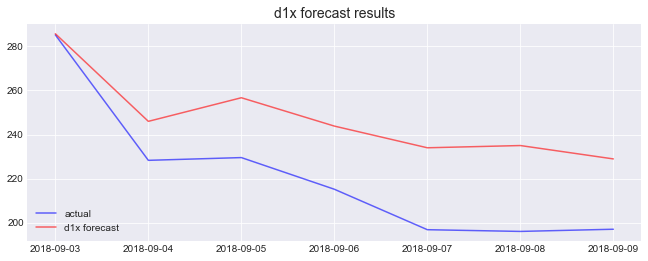

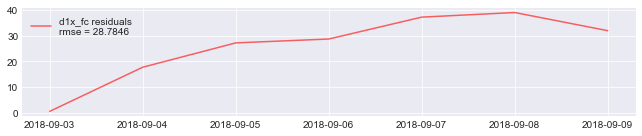

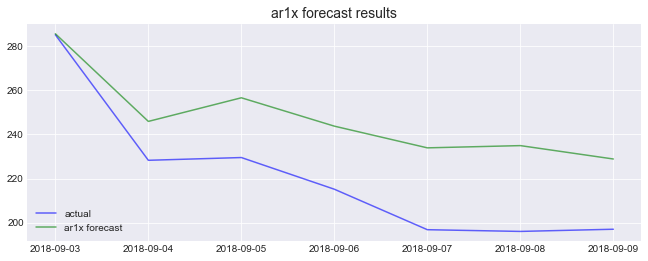

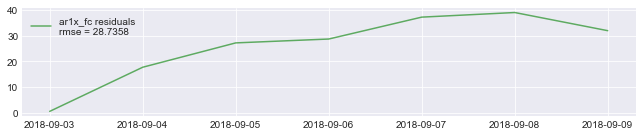

In [33]:
alpha=.6

# d1x forecast results
plt.figure(figsize=(11,4))
plt.title('d1x forecast results', size=14)
plt.plot(
    y_test.index,
    y_test,
    label='actual',
    color='blue',
    alpha=alpha
)
plt.plot(
    y_test.index,
    d1x_fc,
    label='d1x forecast',
    color='red',
    alpha=alpha
)
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(11,2))
plt.plot(
    y_test.index,
    d1x_fc_resid,
    label='d1x_fc residuals\nrmse = {:.4f}'.format(rmse_d1x_fc),
    color='red',
    alpha=alpha
)
plt.legend(loc='upper left')
plt.show()

# ar1x forecast results
plt.figure(figsize=(11,4))
plt.title('ar1x forecast results', size=14)
plt.plot(
    y_test.index,
    y_test,
    label='actual',
    color='blue',
    alpha=alpha
)
plt.plot(
    y_test.index,
    ar1x_fc,
    label='ar1x forecast',
    color='green',
    alpha=alpha
)
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(11,2))
plt.plot(
    y_test.index,
    ar1x_fc_resid,
    label='ar1x_fc residuals\nrmse = {:.4f}'.format(rmse_ar1x_fc),
    color='green',
    alpha=alpha
)
plt.legend(loc='upper left')
plt.show()